# Analisis

## librerias

In [8]:
import numpy as np
from sklearn import linear_model
from matplotlib import pyplot as plt
import pickle

In [9]:
%run codigos/mv_to_ep.ipynb
%run codigos/R_Fresnel.ipynb

## parametros globales de la antena

In [10]:
#-----------------------------------
## Parámetros globales de la antena
#-----------------------------------

Fs = 23.328e9 #Frecuencia de muestreo [Hz] 
Ts = 1/Fs
BW = 1.5e9 
corte = 150
Nfft= 1024 # nro de frecs -> conviene que sea multiplo de 2 para calcular la FFT de manera eficiente. 
#Tiene que ser mayor a la longitud de la señal (285 para 2m, 439 para 3m)

#------------------------------
#Elegir frecuencia portadora
#------------------------------
portadora = input('portadora? (Fc7 o Fc8)')

if portadora == 'Fc7':
    fc = 7.290e9 
    Fc = '7.29GHz'
elif portadora == 'Fc8':
    fc = 8.748e9
    Fc = '8.74GHz'
else:
    print('Error: portadora debe ser Fc7 o Fc8')

In [11]:
#------------------------------
##Elegir fecha de mediciones
#------------------------------
mes = input('mes? (mayo, junio, julio o agosto)')


## Señales

In [12]:
with open('Mediciones/'+mes+'_'+portadora+'.pkl','rb') as g:
    Med = pickle.load(g)
print(Med.keys())
with open('Mediciones/hydra_'+mes+'.pkl','rb') as gg:
    hydra = pickle.load(gg)
print(hydra.keys())

dict_keys(['h1_may', 'h2_may', 'f_may', 'S1_may', 'S2_may'])
dict_keys(['depth_may', 'mv_med_may', 'ep_med_may', 'sigma_may'])


In [13]:
keysList = list(Med.keys())
if mes == 'agosto':
    h1 = Med.get(keysList[0])
    h2 = h1
    f = Med.get(keysList[1])
    S1 = Med.get(keysList[2])
    S2 = Med.get(keysList[4])
    S1B = Med.get(keysList[3])
else:
    h1 = Med.get(keysList[0])
    h2 = Med.get(keysList[1])
    f = Med.get(keysList[2])
    S1 = Med.get(keysList[3])
    S2 = Med.get(keysList[4])

hydraList = list(hydra.keys())

depth = hydra.get(hydraList[0])
mv_med = hydra.get(hydraList[1])
ep_med = hydra.get(hydraList[2])
sigma = hydra.get(hydraList[3])

## Valores para el modelo de suelo

In [14]:
#grilla de valores para MV
mv_min = 0*np.min(mv_med)
mv_max = 1.25*np.max(mv_med)
n_mv = 100
MV = np.linspace(mv_min,mv_max,n_mv)

Sand = 0.5
Clay = 0.5

ep_teo = mv_to_ep(MV,Sand,Clay,0)['ep']

#usando el error
#ep_std = 0.01 #std para estimar el error en ep del modelo teórico
#ep_teo = mv_to_ep(MV,Sand,Clay,ep_std)['ep']
#ep_error = mod.mv_to_ep(MV,Sand, Clay,ep_std)['ep_error']

n_ep = 20
ep_min, ep_max = np.min(ep_teo), np.max(ep_teo)
print('ep min:', ep_min)
print('ep max:', ep_max)
epRange = np.linspace(0.4*ep_min,1.25*ep_max,n_ep)


ep1Range = np.linspace(0.4*ep_min,0.6*ep_max,n_ep)
ep2Range = np.linspace(0.4*ep_max,1.25*ep_max,n_ep)
print('ep1:',ep1Range[0],ep1Range[-1])
print('ep2:',ep2Range[0],ep2Range[-1])


ep min: (2.007-0.198j)
ep max: (22.9023775+5.212148849999998j)
ep1: (0.8028000000000001-0.0792j) (13.7414265+3.1272893099999988j)
ep2: (9.160951+2.0848595399999996j) (28.627971875+6.515186062499998j)


## Modelos

### medio semi-infinito

In [30]:
ind = []
for i in range(len(h1)):
    aux = np.zeros(n_mv,dtype=float)
    for j in range(n_mv):
        ep = ep_teo[j]
    
        #coef de reflexion depende solo de ep
        R = R_1capa(ep)
        S2teo = S1[i]*R
        error = np.sum(np.abs(np.abs(S2teo)-np.abs(S2)))/np.shape(S2)[1]
        ##error
        aux[j] = error  
    ind.append(np.argmin(aux))

print(ind)



[82, 99, 99, 99]


In [23]:
#transformo la lista en un array
ind = np.array(ind)

#si hago ind < 98 obtengo un array de booleans
#asi que si lo pongo entre [] me quedo con el subset de valores que cumplen la condicion (True)
ind = ind[ind < 98]
print(ind)

[82]


In [28]:
def S_teo_A(altura, f, S1, S2, epRange, n_mv):
    ind = []
    for i in range(len(altura)):
        aux = np.zeros(len(epRange),dtype=float)
        for j in range(len(epRange)):
            ep = epRange[j]
        
            #coef de reflexion depende solo de ep
            R = R_1capa(ep)
            S2teo = S1[i]*R
            error = np.sum(np.abs(np.abs(S2teo)-np.abs(S2)))/len(S2teo)
            ##error
            aux[j] = error  
        ind.append(np.argmin(aux))

    for i in range(len(altura)):
        ind_i = ind[i]
        if ind_i < (len(epRange)-1):
            print(ind_i)
            # mv_op = MV[ind[i]]
            ep_op = ep_teo[ind[i]]
            S_op = S1*R_1capa(ep_op)
            # error_mae = e_mae[i,ind[i]]

            plt.figure()    
            plt.plot(f,np.abs(S1[i]), label='medicion S1')
            plt.plot(f,np.abs(S2[i]), label='medicion S2')
            plt.plot(f,np.abs(S_op[i]), label='teorica')
            plt.title('h ~ '+str(altura[i]))
            plt.xlabel('Frecuencia[GHz]')
            plt.ylabel('Amplitud')
            plt.legend(loc="best")
            plt.grid()
            plt.show()
        else:
            print('error')
    
    return ep_op, S_op

In [26]:
#LE FALTA PERFECCIONAMIENTO --> FUNCION EN R_FRESNEL
# plt.figure(figsize=(10,6))
# for i in range(len(h1)):
#     ind_i = ind[i]
#     if ind_i < 99:
#         print(ind_i)
#         mv_op = MV[ind[i]]
#         ep_op = ep_teo[ind[i]]
#         S_op = S1*R_1capa(ep_op)
#         error_mae = aux[ind[i]]

#         plt.plot(f,np.abs(S_op[i]), label='teo')
#         plt.plot(f,np.abs(S2[i]), label='S2 - h='+str(h2[i]))
#         plt.title('Modelo 1 capa lisa')
#         plt.xlabel('Frecuencia [GHz]')
#         plt.ylabel('Amplitud')
#         plt.grid()
#         plt.legend(loc="best")
#     else:
#         print('Indice en el limite del intervalo')

    
# print(np.shape(S_op))

82


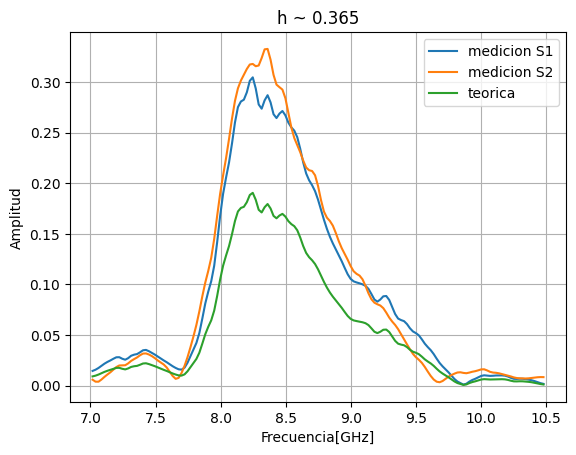

error
error
error
(2,)


In [29]:
S2_teo = S_teo_A(h2, f, S1, S2, ep_teo, n_mv)
print(np.shape(S2_teo))

### Modelo 2 capas

In [ ]:
n_ep = 40
ep1Range = np.linspace(ep_min,0.2*ep_max,n_ep)
ep2Range = np.linspace(1.15*ep_min,2*ep_max,n_ep)

print('ep1:',ep1Range[0],ep1Range[-1])
print('ep2:',ep2Range[0],ep2Range[-1])

# espesor de la primera capa
d_min, d_max, n_d = 0, 0.08, 40
dRange = np.linspace(d_min,d_max,n_d)

print('d:',np.min(dRange),np.max(dRange))

ep1: (2.0118-0.198j) (4.961480000000001+1.11168j)
ep2: (2.31357-0.22769999999999999j) (49.6148+11.1168j)
d: 0.0 0.08


## Análisis por mes

### Agosto

In [ ]:
print(np.shape(S1A_ag), np.shape(S1B_ag))

(2, 153) (2, 153)


altura: h =  0.355
indices optimos para chapa azul: (39, 0, 0)
indices optimos para azul + conductora: (39, 0, 0)
(153,)
(153,)


<Figure size 432x288 with 0 Axes>

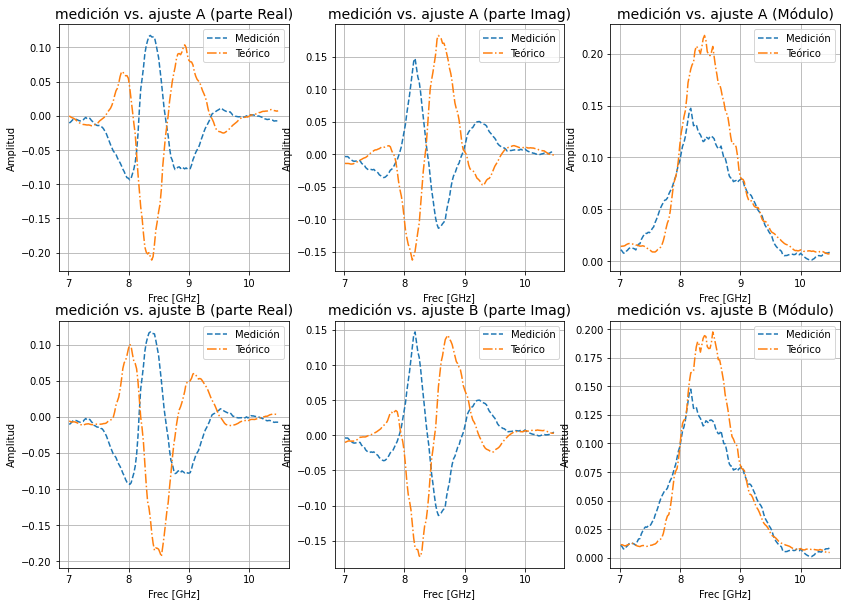

altura: h =  0.435
indices optimos para chapa azul: (39, 0, 0)
indices optimos para azul + conductora: (39, 0, 0)
(153,)
(153,)


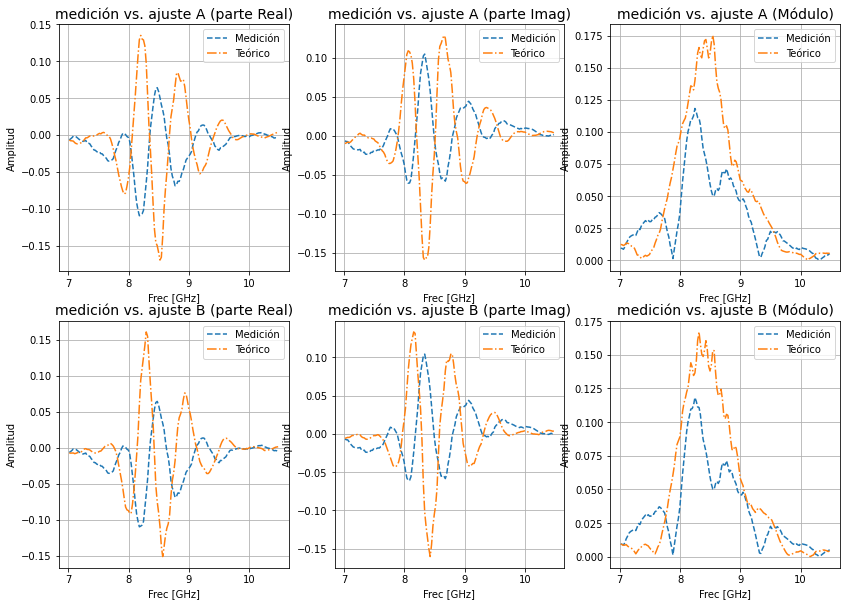

In [ ]:
# vector para guardar el error para (EP1,EP2) usado en el ajuste
Err_A = np.zeros((n_d,n_ep,n_ep),dtype=float)
Err_B = np.zeros((n_d,n_ep,n_ep),dtype=float)

# vector en donde guardo la señal teórica que mejor ajusta a cada medición
DA_opt = np.zeros(len(h_ag), dtype=float)
EP1A_opt = np.zeros(len(h_ag), dtype=complex)
EP2A_opt = np.zeros(len(h_ag), dtype=complex)
DB_opt = np.zeros(len(h_ag), dtype=float)
EP1B_opt = np.zeros(len(h_ag), dtype=complex)
EP2B_opt = np.zeros(len(h_ag), dtype=complex)

# S_optima = np.zeros((len(h_ag),int(np.shape(S1A_ag)[1])), dtype=complex)
# print(np.shape(S_optima))

plt.figure()
for j in range(len(h_ag)):
    for i0 in range(n_d):
        D = dRange[i0]
        for i1 in range(n_ep):
            EP1 = ep1Range[i1]
            for i2 in range(n_ep):
                EP2 = ep2Range[i2]

                # coef de reflexión con EP1, EP2, D
                R = R_ep1_ep2(EP1,EP2,D,f)
                S2A_teo = S1A_ag[j]*R 
                S2B_teo = S1B_ag[j]*R
                ## Calculo métricas de error #
                Err_A[i0,i1,i2] = np.sum(np.abs(np.abs(S2A_teo)-np.abs(S2_ag[j])))/len(S2A_teo)
                Err_B[i0,i1,i2] = np.sum(np.abs(np.abs(S2B_teo)-np.abs(S2_ag[j])))/len(S2B_teo)

    print('altura: h = ',h_ag[j])
    print('indices optimos para chapa azul:', np.unravel_index(Err_A.argmin(),Err_A.shape))
    print('indices optimos para azul + conductora:', np.unravel_index(Err_B.argmin(),Err_B.shape))
    
    indice_da_opt = np.unravel_index(Err_A.argmin(),Err_A.shape)[0]
    DA_opt[j] = dRange[indice_da_opt]
    indice_db_opt = np.unravel_index(Err_B.argmin(),Err_B.shape)[0]
    DB_opt[j] = dRange[indice_db_opt]

    indice_ep1a_opt = np.unravel_index(Err_A.argmin(),Err_A.shape)[1]
    EP1A_opt[j] = ep1Range[indice_ep1a_opt]
    indice_ep1b_opt = np.unravel_index(Err_B.argmin(),Err_B.shape)[1]
    EP1B_opt[j] = ep1Range[indice_ep1b_opt]

    indice_ep2a_opt = np.unravel_index(Err_A.argmin(),Err_A.shape)[2]
    EP2A_opt[j] = ep2Range[indice_ep2a_opt]
    indice_ep2b_opt = np.unravel_index(Err_B.argmin(),Err_B.shape)[2]
    EP2B_opt[j] = ep2Range[indice_ep2b_opt]

    # Señal optima:
    RA_opt = R_ep1_ep2(EP1A_opt[j],EP2A_opt[j],DA_opt[j],f) 
    S2A_opt = S1A_ag[j,:]*RA_opt
    print(np.shape(S2A_opt))
    RB_opt = R_ep1_ep2(EP1B_opt[j],EP2B_opt[j],DB_opt[j],f) 
    S2B_opt = S1B_ag[j,:]*RB_opt
    print(np.shape(S2B_opt))

    fig , ax = plt.subplots(nrows=2, ncols=3, figsize=(14,10))

    ax[0,0].plot(f,np.real(S2_ag[j,:]),'--',label='Medición')
    ax[0,0].plot(f,np.real(S2A_opt),'-.',label='Teórico')
    ax[0,0].grid('on')
    ax[0,0].legend(loc="best",fontsize=10)
    ax[0,0].set_xlabel('Frec [GHz]')
    ax[0,0].set_ylabel('Amplitud')
    ax[0,0].set_title( 'medición vs. ajuste A (parte Real)', fontsize=14) #, fontstyle='normal')

    ax[0,1].plot(f,np.imag(S2_ag[j,:]),'--',label='Medición')
    ax[0,1].plot(f,np.imag(S2A_opt),'-.',label='Teórico')
    ax[0,1].grid('on')
    ax[0,1].legend(loc="best",fontsize=10)
    ax[0,1].set_xlabel('Frec [GHz]')
    ax[0,1].set_ylabel('Amplitud')
    ax[0,1].set_title( 'medición vs. ajuste A (parte Imag)', fontsize=14) #, fontstyle='normal')

    ax[0,2].plot(f,np.abs(S2_ag[j,:]),'--',label='Medición')
    ax[0,2].plot(f,np.abs(S2A_opt),'-.',label='Teórico')
    ax[0,2].grid('on')
    ax[0,2].legend(loc="best",fontsize=10)
    ax[0,2].set_xlabel('Frec [GHz]')
    ax[0,2].set_ylabel('Amplitud')
    ax[0,2].set_title( 'medición vs. ajuste A (Módulo)', fontsize=14) #, fontstyle='normal')

    ax[1,0].plot(f,np.real(S2_ag[j,:]),'--',label='Medición')
    ax[1,0].plot(f,np.real(S2B_opt),'-.',label='Teórico')
    ax[1,0].grid('on')
    ax[1,0].legend(loc="best",fontsize=10)
    ax[1,0].set_xlabel('Frec [GHz]')
    ax[1,0].set_ylabel('Amplitud')
    ax[1,0].set_title( 'medición vs. ajuste B (parte Real)', fontsize=14) #, fontstyle='normal')

    ax[1,1].plot(f,np.imag(S2_ag[j,:]),'--',label='Medición')
    ax[1,1].plot(f,np.imag(S2B_opt),'-.',label='Teórico')
    ax[1,1].grid('on')
    ax[1,1].legend(loc="best",fontsize=10)
    ax[1,1].set_xlabel('Frec [GHz]')
    ax[1,1].set_ylabel('Amplitud')
    ax[1,1].set_title( 'medición vs. ajuste B (parte Imag)', fontsize=14) #, fontstyle='normal')

    ax[1,2].plot(f,np.abs(S2_ag[j,:]),'--',label='Medición')
    ax[1,2].plot(f,np.abs(S2B_opt),'-.',label='Teórico')
    ax[1,2].grid('on')
    ax[1,2].legend(loc="best",fontsize=10)
    ax[1,2].set_xlabel('Frec [GHz]')
    ax[1,2].set_ylabel('Amplitud')
    ax[1,2].set_title( 'medición vs. ajuste B (Módulo)', fontsize=14) #, fontstyle='normal')
    plt.show()

    # print('d_opt:', str(round(100*D_opt,3))+' cm')
    # print('comparo con las mediciones medidas para depth=', depth[1])
    # print()
    # print('ep1_opt:',round(np.real(EP1_opt),3))
    # print('ep1_medido (2,5cm):', ep_med[1])
    # print()
    # print('ep2_opt:',round(np.real(EP2_opt),3))
    # print('ep2_medido (7cm):',ep_med[2])